In [1]:
import h5py
import networkx as nx
import numpy as np

# With water

Simulation with water.

In [4]:
h5 = h5py.File('p_1.0_25699_25699_traj.h5')

In [5]:
h5['/connectivity/'].keys()

[u'bonds_0', u'chem_bonds_0']

In [14]:
cl = h5['/connectivity/chem_bonds_0/value']
st_cl = filter(lambda x: -1 not in x, h5['/connectivity/bonds_0'])
st = filter(lambda x: x != -1, h5['/particles/atoms/state/value'][-1])
sp = filter(lambda x: x != -1, h5['/particles/atoms/species/value'][-1])
sp_t = h5['/particles/atoms/species/value']
id_t = h5['/particles/atoms/id/value']
pid2res_id = {p: p for p in range(1, 1001)}
pid2res_id.update({pid: 1001+(pid-1001)//3 for pid in range(1001, 4001)})

In [18]:
(id_t[0][np.where(sp_t[0]==2)[0]] == id_t[0][np.where(sp_t[0]==2)[0]]).all()

True

In [94]:
g0 = nx.Graph()
g0.add_nodes_from(range(1, 4001))
g0.add_edges_from(st_cl)
g0.add_edges_from(filter(lambda b: -1 not in b, cl[-1]))
np.average([sg.number_of_nodes() for sg in nx.connected_component_subgraphs(g0)])

25.477707006369428

In [95]:
from networkx.drawing.nx_agraph import graphviz_layout
def draw_graph(g, **kwargs):
    g_degree = g.degree()
    pos = graphviz_layout(g)
    node_colors = {1: 'r', 2: 'g', 3: 'y', 4: 'b'}
    
    nx.draw_networkx(g, pos, node_size=500, font_size=12, alpha=0.5, labels=g_degree,
                     node_color=[node_colors[g_degree[x]] for x in g.nodes()], **kwargs)
    plt.xticks([])
    plt.yticks([])

In [96]:
g160 = sorted([(sg.number_of_nodes(), sg) for sg in nx.connected_component_subgraphs(g0)])[-1][1]

In [97]:
dd = g160.degree().values()
{d: dd.count(d) for d in set(dd)}

{1: 2, 2: 158}

In [98]:
cg160 = nx.Graph()
for b in g160.edges():
    r1, r2 = map(pid2res_id.get, b)
    if r1 != r2:
        cg160.add_edge(r1, r2)

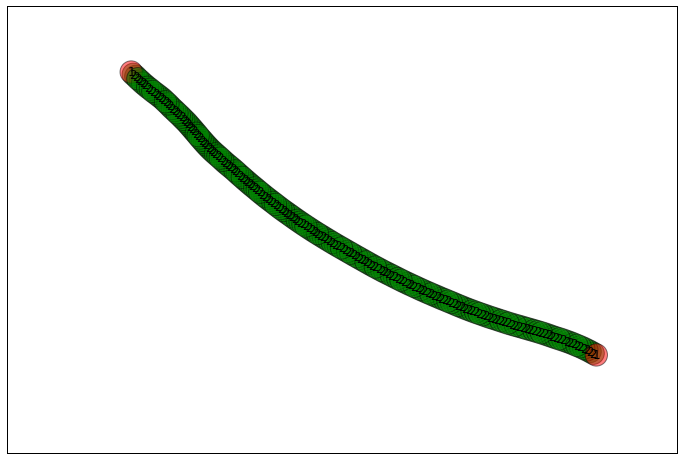

In [99]:
draw_graph(sorted([(sg.number_of_nodes(), sg) for sg in nx.connected_component_subgraphs(g0)])[-1][1])

In [101]:
cg160.number_of_nodes()

80

In [104]:
cr_pn = []
last_cr = -1
static_b = {tuple(sorted(map(pid2res_id.get, b))) for b in st_cl}
static_b = filter(lambda b: b[0] != b[1], static_b)
for t_cl in h5['/connectivity/chem_bonds_0/value']:
    s_cl = filter(lambda x: -1 not in x, t_cl)
    if len(s_cl) != last_cr:
        g = nx.Graph()
        g.add_nodes_from(range(1, 2001))
        g.add_edges_from(static_b)
        g.add_edges_from({tuple(sorted(map(pid2res_id.get, b))) for b in s_cl})
        cr_pn.append([len(s_cl), np.average([sg.number_of_nodes() for sg in nx.connected_component_subgraphs(g)])])
        last_cr = len(s_cl)
cr_pn = np.array(cr_pn)

In [106]:
def theory_pn(p):
    return 1.0/(1.0-p)

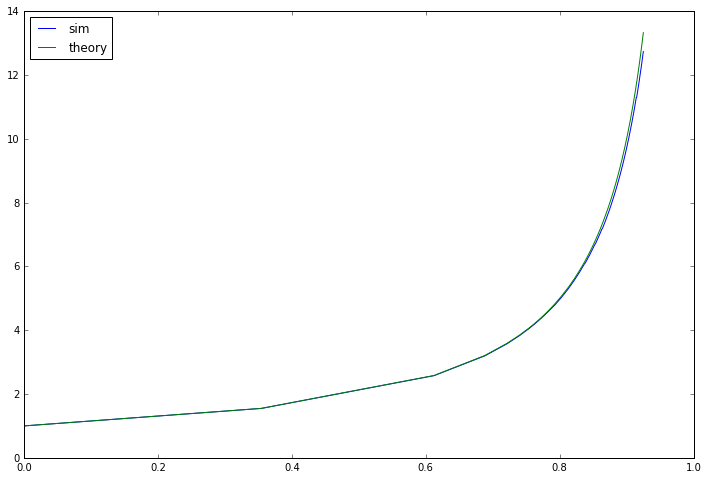

In [109]:
plt.plot(cr_pn[:, 0]/2000.0, cr_pn[:, 1], label='sim')
plt.plot(cr_pn[:, 0]/2000.0, map(theory_pn, cr_pn[:, 0]/2000.0), label='theory')
plt.legend(loc=0)

In [116]:
def px(p):
    def pp(x):
        return (1.0-p)*(p**(x-1))
    return pp

In [123]:
x = np.arange(1, 10, 0.1)

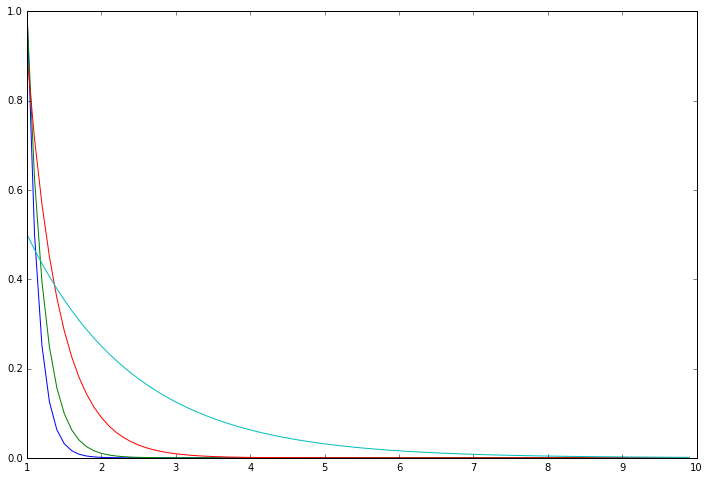

In [127]:
plt.plot(x, map(px(0.001), x))
plt.plot(x, map(px(0.01), x))
plt.plot(x, map(px(0.1), x))
plt.plot(x, map(px(0.5), x))